# Concept Drift Detection with `alibi-detect` 
### (Code implemented from EuroPython – The Largest European Python Conference 2021)

This notebook demonstrate how drift detection can be performed in an online manner on a medical imaging problem of real practical interest.

In [3]:
## Import libraries

from typing import Tuple, Generator, Callable, Optional  # for type hints, ermöglicht, die erwarteten Typen von Eingaben und Ausgaben von Funktionen zu spezifizieren 
    # (nicht zwingend erforderlich, aber hilfreich, um Fehler zu vermeiden)
    #
    # Tuple:        Ein Tuple ist eine geordnete Liste von Werten. Ein Tuple ist unveränderlich, d.h. Typ (und unveränderliche) Werte können nicht geändert werden.
    # Generator:    Ein Generator in Python ist eine spezielle Art von Funktion, die eine Sequenz von Werten zurückgibt. Anstatt alle Werte auf einmal zu generieren und 
    #               in einer Liste zu speichern, generiert ein Generator die Werte on-the-fly und gibt sie einzeln aus. 
    # Callable:     Callable bedeutet, dass es eine Funktion oder ein anderes aufrufbares Objekt sein sollte.
    # Optional:     Optional bedeutet, dass es sich um einen Wert handeln kann, der None sein kann.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
print(torch.__version__)

from torch.utils.data import TensorDataset, DataLoader   
    # TensorDataset":  Hilfsklasse in PyTorch, die ein Dataset aus einem oder mehreren Tensoren erstellt. Dies ist nützlich, wenn Sie zusammenhängende Tensoren haben 
    #   (Merkmale+Label), die Sie in einem Dataset zusammenfassen möchten.
    # DataLoader":     Hilfsklasse in PyTorch, die ein Dataset lädt und in Batches aufteilt. Zufälliger oder sequentieller durchlauf möglich.
import torchvision.transforms as transforms             
    # torchvision ist eine Bibliothek, die beliebte Datensätze, Modellarchitekturen und gängige Bildtransformationen für Computer Vision bereitstellt.
from wilds.common.data_loaders import get_train_loader   
    # Benchmark für die Verteilung von Datensätzen für maschinelles Lernen, bietet eine Reihe von Datensätzen und Auswertungsprotokollen für die Untersuchung 
    #   des Problems der Verteilungsverschiebung, bei der die Testdaten aus einer anderen Verteilung stammen als die Trainingsdaten
    # get_train_loader":  Hilfsfunktion, die einen DataLoader für Trainingsdaten zurückgibt.
from wilds import get_dataset
    # get_dataset":  Hilfsfunktion, die einen Benchmark-Datensatz zurückgibt/ einlädt.


torch.manual_seed(42)  # Setzt den Zufallszahlengenerator auf einen bestimmten Wert, um die Reproduzierbarkeit zu gewährleisten.

np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

2.1.2+cpu


## Data

The Camelyon17 medical imaging dataset, one of the [WILDS](https://wilds.stanford.edu/) datasets of *Koh et al.* (2020) that represent "in-the-wild" distribution shifts for various data modalities. It contains tissue scans to be classificatied as benign or cancerous. The pre-change distribution corresponds to a mixture of scans from across three hospitals and the post-change distribution corresponds to scans from a new fourth hospital.

*Koh et al. (2020)* show that models trained on scans from the pre-change distribution achieve an accuracy of 93.2% on unseen scans from same distribution, but only 70.3% accuracy on scans from the post-change distribution.

<br>

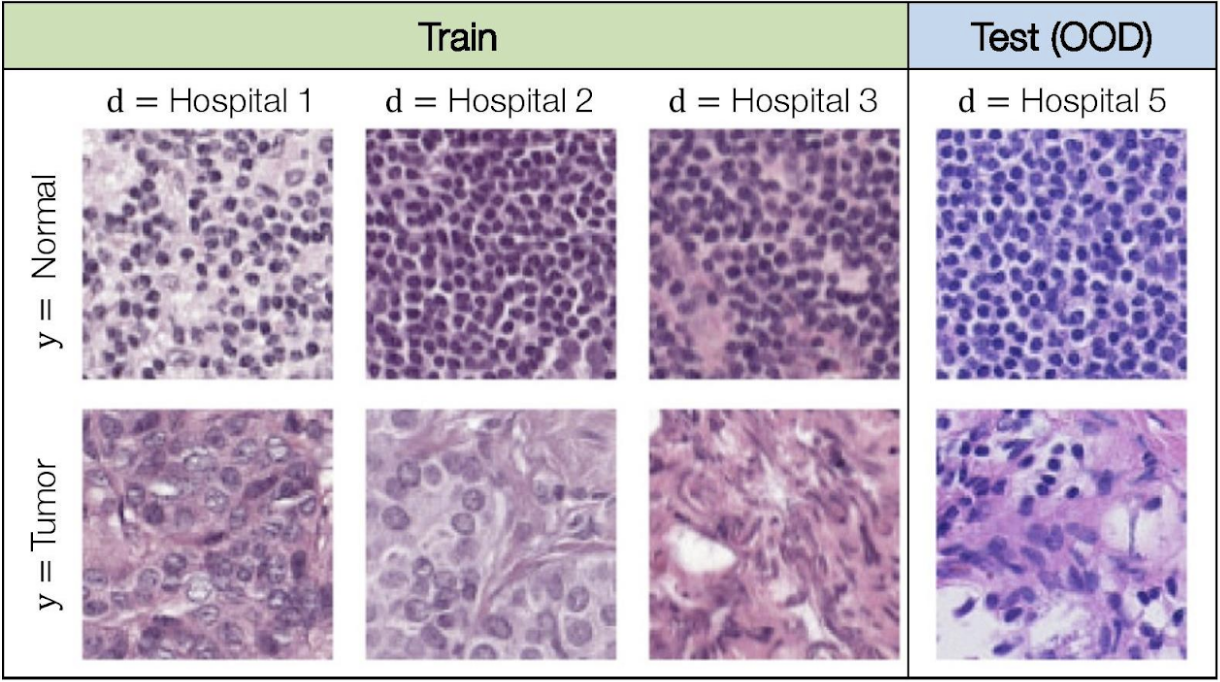 

As can be seen in the image above, the tissue scans from hospital 5 (image on the right) differ from the other hospitals. The color appears more blue and contrasty, which is due, for example, to the fact that a different cell staining technique was used under the microscope or the demographic distribution of the patients is different.

If a change occurs in one of the hospitals or a new hospital wants to use the model, the performance under training conditions can no longer be guaranteed and (more frequent) misdiagnoses may occur. This life-critical reason shows why the detection of concept drift and thus the robustness of the ML model is of crucial importance.

In [4]:
WILDS_PATH = '/home/data/wilds' # Path where you'd like to save/load data to/from (11 GB)
DOWNLOAD = False                # set to True for first run
N = 2500                        # size of reference set

`Wilds` library can be used to load and resize the data. 
<br>
Then the custom function converts the various splits of data into streams in order to simulate a live deployment environment.

In [5]:
#Custom function to load and stream the Camelyon17 dataset.
def stream_camelyon(
    split: str='train',             # split variable should be a string, either 'train', 'val', or 'test'
    img_size: Tuple[int]=(96,96),   # img_size variable should be a tuple of integers, e.g. (96,96)
    root_dir: str=None,             # root_dir variable should be a string, e.g. '/home/data/wilds' or None for no initial directory path
    download: bool=False            # download variable should be a boolean
) -> Generator:                     # Function stream_camelyon returns a generator

    camelyon = get_dataset('camelyon17', root_dir=root_dir, download=download)  # returns a dataset and assigns it to the variable camelyon
    ds = camelyon.get_subset(                                                   # returns a modified subset of the dataset and assigns it to the variable ds
        split, 
        transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    )
    ds_iter = iter(get_train_loader('standard', ds, batch_size=1))              # returns a DataLoader and assigns it to the variable ds_iter
        # standard:     Standard data loader for a standard supervised learning task.
        # batch_size:   How many samples per batch to load (default: 1).

    while True:                                                                # while loop, that runs until it is interrupted
        try:    
            img = next(ds_iter)[0][0]           # returns the next batch (picture) from the iterator and assigns it to the variable img,
                                                # assumes that the batch is a 2D tensor, so the first index is the batch index and the second index is the image index
        except Exception:
            ds_iter = iter(get_train_loader('standard', ds, batch_size=1))  # if exception occurs, create a new iterator
            img = next(ds_iter)[0][0]                                       # and start again from the beginning
        yield img.numpy()                                                   # returns the image as a numpy array   

Then a single reference set of size $N$ is simulated from the training distribution.
Furthermore, two data streams are defined: one with the same underlying distribution as the training data (no change) and one with a slightly different distribution (change) corresponding to the previously unseen fourth hospital which can be described as concept drift.

### How to evaluate online drift detectors?

The drift detector should have the following properties: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; with (T':= drift occurs, T*:= drift detected)
- Fast response time (i.e. Expected Detectionn Delay)  <br>
`EDD` = $\Delta$[T'-T*] $\rightarrow$ small, 
- Ability to specify frequency of false detections in the absence of change (i.e. Expected Run Time) <br>
`ERT` = $\Delta$[T'|T*=$\infty$] $\rightarrow$ high.

There is an `ERT` vs `EDD` tradeoff. Low detection delay requires sensitivity and therefore prone to natural fluctuation which results with higher false alarm rates.

By looking at the average run time of a detector on the unchanged stream we can get an idea of the frequency of false alarms (`ERT`) and by looking at the average run time on the changed stream we can get an idea of how quickly the detector is able to identify change when it occurs (`EDD`).

In [20]:
stream_train = stream_camelyon(split='train', root_dir=WILDS_PATH, download=DOWNLOAD)       # returns a generator from the train split
x_ref = np.stack([next(stream_train) for _ in range(N)], axis=0)                   # list calls the generator N times and returns a list of N first images as numpy array
stream_unchanged = stream_camelyon(split='id_val', root_dir=WILDS_PATH, download=DOWNLOAD)  # returns a generator from the id_val split
stream_changed = stream_camelyon(split='test', root_dir=WILDS_PATH, download=DOWNLOAD)      # returns a generator from the test split

Shown below are samples from the unchanged stream:

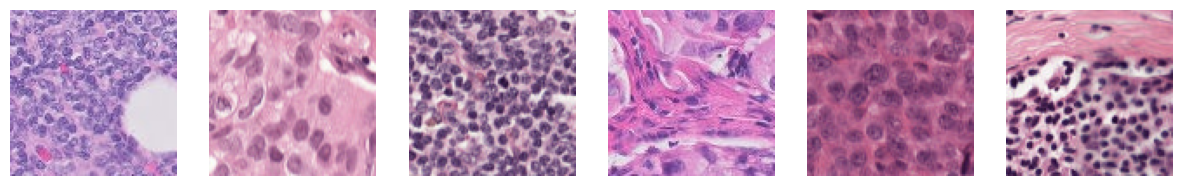

In [27]:
# Plot unchanged images
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))                     # creates a figure and a set of subplots, axs is an array of Axes objects
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_unchanged), (1,2,0)))    # rearranges the dimensions of the array to the order (1,2,0), because imshow expects the color 
                                                                    #   channels to be the last dimension but in many datasets, they are the first dimension.
    axs[i].axis('off')                                              # turns off the axis lines and labels

And samples from the changed stream:

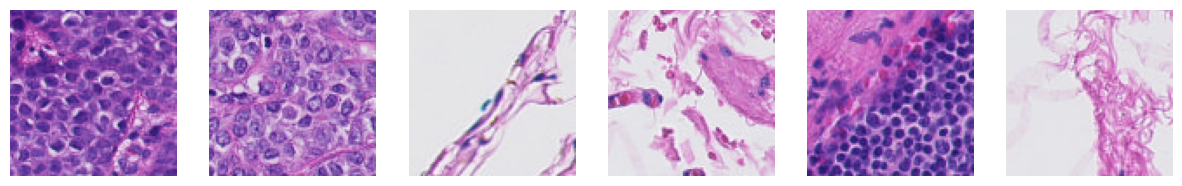

In [25]:
# Plot changed images
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_changed), (1,2,0)))  # rearranges the dimensions of the array to the order (1,2,0), because imshow expects the color 
                                                                #   channels to be the last dimension but in many datasets, they are the first dimension.
    axs[i].axis('off')                                          # turns off the axis lines and labels

## Drift Detection

Drift Detection macht primär im Online Modus Sinn, wo die Daten in einem kontinuierlichen Modus eintreffen und Veränderungen im laufenden Betrieb auftreten können.
Ein sokches Streaming-Szenario liegt nun vor und die Implementation eines Algorithmus folgt in den nachfolgenden Schritten.

Die aktive Erkennung von Drift mittels Driftdetektor kann auf unterschiedlichen Prinzipien basieren, nachfolgend beispielhaft aufgeführt:
<br> (Die Einteilung der Kategorien ist in der Literatur **nicht** konsistent!)

| Label availability| Category | Example Method | Merkmal |
|-------------------|----------|----------------|---------|
|                   | Statistical Process Control    | DDM    | Samples go up, error should go down     |
| Supervised        | Sequential Analysis     | LFR     |      |
|                   | Data     | Data     |Data     |

wo habe ich die beispiele gefunden (bzw wie komme ich auf die erklärungen? paper raussuchen...
einbau von erklärungne aus alibi detect)

We will adopt the strategy of overlapping windows and use as the test statistic an estimator of Maximum Mean Discrepancy $MMD_k$ that can be updated incrementally.

### Kernel

Rather than apply a simple kernel directly to the high dimensional (96x96x3) scans we will define a more meaningful kernel by projecting onto a more structured lower dimensional space before applying a simple (Gaussian) kernel. We learn the structured representation by training a convolutional autoencoder and then using the encoder. It is important that trained preprocessing components are trained on a split of data that doesn't then form part of the reference data passed to the drift detector.

In [9]:
ENC_DIM = 32
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3

In [10]:
encoder = nn.Sequential(
    nn.Conv2d(3, 8, 5, stride=3, padding=1),    # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.Conv2d(8, 12, 4, stride=2, padding=1),   # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(12, 16, 4, stride=2, padding=1),   # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 20, 4, stride=2, padding=1),   # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.Conv2d(20, ENC_DIM, 4, stride=1, padding=0),   # [batch, enc_dim, 1, 1]
    nn.Flatten(), 
)
decoder = nn.Sequential(
    nn.Unflatten(1, (ENC_DIM, 1, 1)),
    nn.ConvTranspose2d(ENC_DIM, 20, 4, stride=1, padding=0),  # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.ConvTranspose2d(20, 16, 4, stride=2, padding=1),  # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.ConvTranspose2d(12, 8, 4, stride=2, padding=1),  # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.ConvTranspose2d(8, 3, 5, stride=3, padding=1),   # [batch, 3, 96, 96]
    nn.Sigmoid(),
)
ae = nn.Sequential(encoder, decoder).to(device)

x_fit, x_ref = np.split(x_ref, [len(x_ref)//2])
x_fit = torch.as_tensor(x_fit)
x_fit_dl = DataLoader(TensorDataset(x_fit, x_fit), BATCH_SIZE, shuffle=True)

We can train the autoencoder using a helper function provided for convenience in `alibi-detect`.

In [11]:
from alibi_detect.models.pytorch import trainer

trainer(ae, nn.MSELoss(), x_fit_dl, device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Epoch 5/5: 100%|██████████| 40/40 [00:01<00:00, 23.46it/s, loss_ma=0.0232]


The preprocessing/projection functions are expected to map numpy arrays to numpy arrays, so we wrap the encoder within the function below.

In [12]:
def encoder_fn(x: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x).to(device)
    with torch.no_grad():
        x_proj = encoder(x)
    return x_proj.cpu().numpy()

### Defining the detector

Defining the detector is as simple as importing the desired detector from `alibi_detect` and passing the reference data, desired ERT, and window size. The thresholds are configured via simulation in an initial configuration phase. The thresholds vary for the first few time-steps to account for correlation between consecutive test statistics.

In [13]:
ERT = 150  # expected run-time in absence of change
W = 20  # size of test window
B = 100_000  # number of simulations to configure threshold

In [14]:
from alibi_detect.cd import MMDDriftOnline

dd = MMDDriftOnline(x_ref, ERT, W, backend='pytorch', preprocess_fn=encoder_fn)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


### Applying the detector

The detector can then be used by passing instances from the stream to the detector's `.predict()` method one at a time. The `.predict()` method returns a dictionary of useful information, most notably whether it believes drift has occured. We iterate through the stream inside the `compute_runtime` function which takes the detector and a stream as arguments and returns the time step at which the detector flags drift on that stream.

In [15]:
def compute_runtime(detector: Callable, stream: Generator) -> int:
    
    detector.reset_state()
    detected = False
    
    while not detected:
        z = next(stream)
        pred = detector.predict(z)
        detected = pred['data']['is_drift']
        
    print(detector.t)
    return detector.t

We see that on the unchanged stream the detector achieves runtimes that are on average close to the ERT. The runtimes listed below correspond to a single set of calibrated thresholds, however if we averaged runtimes over a large number of calibrations then we would see the desired ERT is being targeted.

In [16]:
times_h0 = [compute_runtime(dd, stream_unchanged) for i in range(15)]
print(f"Average runtime in absence of change: {np.array(times_h0).mean()}")

21
164
324
50
36
213
160
33
574
95
97
66
283
25
284
Average runtime in absence of change: 161.66666666666666


We may look under the hood at the trajectory of the test statistic and see how it ended up crossing the threshold by looking at the `.test_stats` and `.thresholds` properties. We see here that the threshold was eventually crossed at time 163 (this corresponds to the final time shown above).

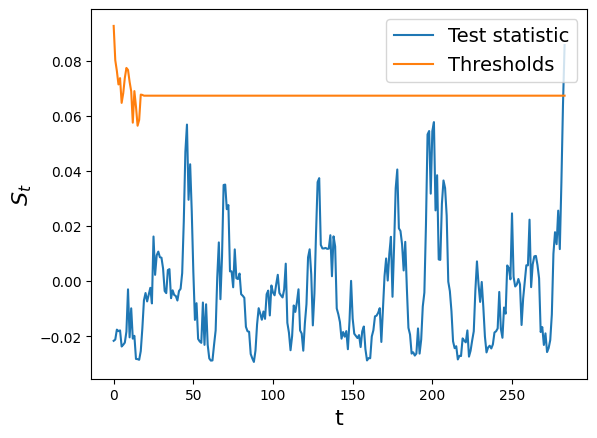

In [17]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$S_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

We now see that when applied to the changed stream the detector is much quicker to make detections, as should any good drift detector.

In [18]:
times_h1 = [compute_runtime(dd, stream_changed) for i in range(15)]
print(f"Average runtime in the presence change: {np.array(times_h1).mean()}")

14
11
25
14
16
14
8
15
11
17
15
14
8
14
14
Average runtime in the presence change: 14.0


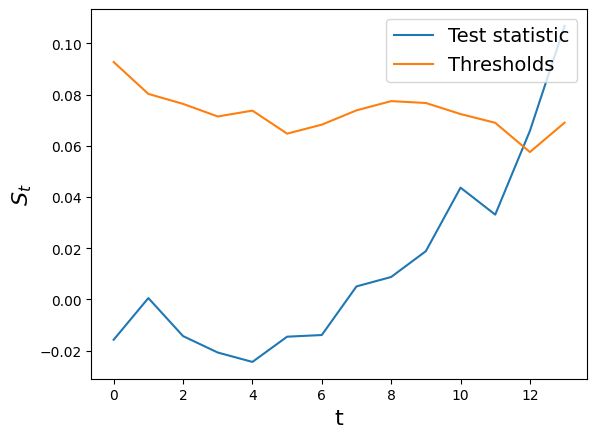

In [19]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$S_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()